In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neenamaryalex","key":"e428483a572b398502b259d40a37f628"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:42<00:00, 24.7MB/s]
100% 2.29G/2.29G [01:42<00:00, 24.1MB/s]


In [3]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [10]:
from keras.models import load_model
from keras.layers import Activation,Dense,Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

from keras.applications.vgg19 import VGG19
from keras.models import Model

In [11]:
def Build_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Transfer VGG Model 
    # -------------------------------------------------------------------------
    # load VGG model
    vgg = VGG19(include_top=True, input_shape=(224, 224, 3))
    
    # mark loaded layers as trainable
    for layer in vgg.layers:
	    layer.trainable = True       
	       
    #  Flatten and Fully Connected Layer
    Flat_layer = Flatten()(vgg.layers[11].output)

    FC_layer = Dense(100)(Flat_layer)    
       
    Act_layer = Activation('relu')(FC_layer)
    
    #  Softmax Classifier
    Class_layer = Dense(2)(Act_layer)
    
    Softmax_layer = Activation('softmax')(Class_layer)

    	# define new model    
    model = Model(inputs=vgg.inputs, outputs=Softmax_layer)
            
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 

     
   
# train and evalluate cnn model
        

In [12]:
def Train_CNN_Model(model):
# -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    # create data generators    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
   
   # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('/content/chest_xray/train',batch_size=batch_size, target_size=(224, 224))
    valid_it = valid_datagen.flow_from_directory('/content/chest_xray/val',batch_size=batch_size, target_size=(224, 224))


    epochs=25;
    
    history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model2.h5')

In [13]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('/content/chest_xray/test', 
                                               shuffle=False,batch_size=batch_size, target_size=(224, 224))
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5

    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()
    

In [14]:
# main entry
    
model = Build_CNN_Model()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/25
163/163 [==============================] - 134s 814ms/step - loss: 15.3009 - accuracy: 0.7278 - val_loss: 0.7554 - val_accuracy: 0.5000
Epoch 2/25
163/163 [==============================] - 132s 808ms/step - loss: 0.5221 - accuracy: 0.7552 - val_loss: 1.1318 - val_accuracy: 0.6875
Epoch 3/25
163/163 [==============================] - 131s 804ms/step - loss: 0.3695 - accuracy: 0.8282 - val_loss: 0.9892 - val_accuracy: 0.5625
Epoch 4/25
163/163 [==============================] - 130s 797ms/step - loss: 0.2984 - accuracy: 0.8671 - val_loss: 0.4753 - val_accuracy: 0.8125
Epoch 5/25
163/163 [==============================] - 130s 797ms/step - loss: 0.2525 - accuracy: 0.8969 - val_loss: 0.7140 - val_accuracy: 0.6250
Epoch 6/25
163/163 [==============================] - 130s 799ms/step - loss: 0.2498 - accuracy: 0.8963 - val_loss: 0.4878 - val_accuracy: 0.6875
Epoch 7/25
163/163 [=====================

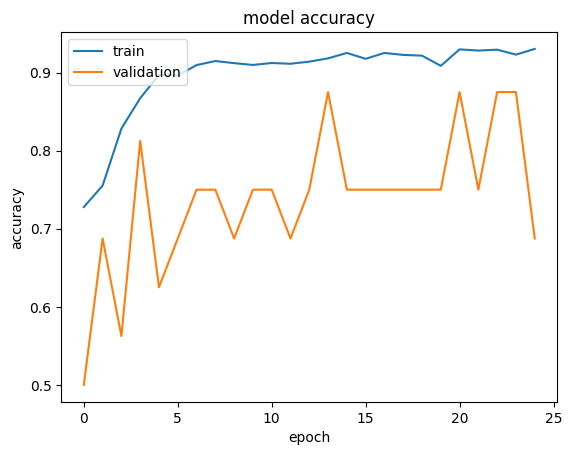

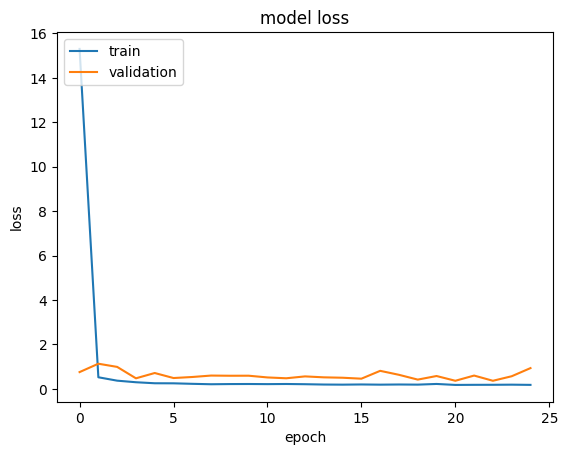

In [15]:
Train_CNN_Model(model)

In [18]:

Evaluate_CNN_Model()


OSError: ignored